
# **COMP9414 Artificial Intelligence**
## Tutorial 1: Agents

@Author: **Wayne Wobcke**

### Objective

Welcome to the first topic of COMP9414 Artificial Intelligence! This week, we will look into the behaviour of a very simple "predator-prey" agent in a dynamically changing environment. We will see how the performance of the agent is influenced by both its reasoning, memory and perception, and the nature of the environment. The key consequence is that what counts as "intelligence" for the agent is a function of the agent's interaction with the environment. The same applies to human agents, though the environments are much more complex.

### Before the tutorial

Review the lecture material, particularly the lecture on Agents. Set up your Python environment and download the `aipython` code for next week.

### 1. Define the Hunter Agent Simulation

The "hunter" agent is a simple agent that operates in a grid environment foraging for food.
We will begin by creating the ```Environment``` class, which simulates a grid world with food in it and a ticking clock that might make food disappear.

In [3]:
# -*- coding: utf-8 -*-

from scipy.spatial import distance
import random

class Environment():
    # Maintains a set of food and computes percepts and effects of agent actions
    # Actions are always successful if feasible
    # Only one food item can be in any location
    
    # Parameters
    # grid_end = 9: end coordinate of grid in X and Y direction, numbered from 0
    # init_food = 5: initial number of food items
    # food_del_chance = 0.05: probabilty of food item disappearing on each clock tick
    # food_add_chance = 0.20: probabilty of food item appearing on each clock tick

    def __init__(self, grid_end=9, init_food=5, food_del_chance=0.05, food_add_chance=0.20):
        self.grid_end = grid_end
        self.grid_size = grid_end + 1
        self.init_food = init_food
        self.food_del_chance = food_del_chance
        self.food_add_chance = food_add_chance
        self.food = set()
        for i in range(self.init_food):
            X = random.randint(0, self.grid_end)
            Y = random.randint(0, self.grid_end)
            if not ((X,Y) in self.food):
                self.food.add((X,Y))
        print("Food at", end=" ")
        print(self.food)
                
    # food items in agent's field of view
    def get_percepts(self, agent):
        (agentX,agentY) = agent.location
        return {(X,Y) for (X,Y) in self.food if distance.euclidean((agentX,agentY), (X,Y)) <= agent.horizon}
    
    # consume food, add 1 to agent's score
    def eat(self, agent):
        if agent.location in self.food:
            self.food.remove(agent.location)
            agent.score += 1
        
    # movement actions
    def move_left(self, agent):
        (X,Y) = agent.location
        if X > 0:
            return (X-1,Y)
        else:
            return (X,Y)

    # Movement actions
    def move_right(self, agent):
        (X,Y) = agent.location
        if X < self.grid_end:
            return (X+1,Y)
        else:
            return (X,Y)
        
    def move_up(self, agent):
        (X,Y) = agent.location
        if Y < self.grid_end:
            return (X,Y+1)
        else:
            return (X,Y)
        
    def move_down(self, agent):
        (X,Y) = agent.location
        if Y > 0:
            return (X,Y-1)
        else:
            return (X,Y)
    
    # Environment update function
    def clock_tick(self):
        # possibly delete food items -- copy elements not deleted into new set
        food_set = set()
        for location in self.food:
            r = random.random()
            if (r > self.food_del_chance):
                food_set.add(location)
            else:
                print("Food disappears at", end=" ")
                print(location)
        self.food = food_set
        # possibly add new food item in random location
        r = random.random()
        if (r < self.food_add_chance):
            X = random.randint(0, self.grid_end)
            Y = random.randint(0, self.grid_end)
            if not ((X,Y) in self.food):
                self.food.add((X,Y))             
                print("Food appears at", end=" ")
                print((X,Y))

We can now define the agent class, which will take an environment and implement an agent cycle within the environment.

In [4]:
class Agent():
    # Agent maintains set of food items seen...but does not update it very well
    # Agent starts at random position
    
    # Parameter
    # horizon = 10 # the agent can only see food up to this distance
    
    def __init__(self, env, horizon=10):
        self.env = env
        self.horizon = horizon # the agent can only see food up to this distance
        self.location = (random.randint(0, env.grid_end),random.randint(0, env.grid_end))
        self.food_seen = set()
        self.score = 0
        print("Agent at", end=" ")
        print(self.location)
        
    def cycle(self):
        # perception
        percepts = self.env.get_percepts(self)
        self.food_seen.update(percepts)  # add new perceived food to set of food seen
        # deliberate mistake: should we delete items that have disappeared?
        
        # action selection and belief update
        if self.food_seen == set():      # if no food on the list, simply move right
            self.location = self.env.move_right(self)
            print("Agent performs move_right to", end=" ")
            print(self.location)
        else:
            # Move towards nearest location in food_seen according to Manhattan distance
            min_d = min(distance.cityblock(self.location, (X,Y)) for (X,Y) in self.food_seen)
            if min_d == 0:
                self.env.eat(self)
                print("Agent performs eat at", end=" ")
                print(self.location)
                self.food_seen.remove(self.location)
            else:
                best = {(X,Y) for (X,Y) in self.food_seen if distance.cityblock(self.location, (X,Y)) == min_d}
                (agentX,agentY) = self.location
                (X,Y) = best.pop()
                if agentX < X:
                    self.location = self.env.move_right(self)
                    print("Agent performs move_right to", end=" ")
                    print(self.location)
                elif agentX > X:
                    self.location = self.env.move_left(self)
                    print("Agent performs move_left to", end=" ")
                    print(self.location)
                elif agentY < Y:
                    self.location = self.env.move_up(self)
                    print("Agent performs move_up to", end=" ")
                    print(self.location)
                else:
                    self.location = self.env.move_down(self)
                    print("Agent performs move_down to", end=" ")
                    print(self.location)


### 2. Run the Hunter Agent Simulation

Create an `Environment` object and an `Agent` object and iteratively call the `clock_tick` and `cycle` methods. The `Agent` object maintains its score.

In [5]:
# Parameters
# grid_end = 9: end coordinate of grid in X and Y direction, numbered from 0
# init_food = 5: initial number of food items
# food_del_chance = 0.05: probabilty of food item disappearing on each clock tick
# food_add_chance = 0.20: probabilty of food item appearing on each clock tick
env = Environment(9, 10, 0.05, 0.20)

# Parameters
# env: the environment the agents operates in
# horizon = 10: the agent can only see food up to this distance away
agent = Agent(env, 10)

steps = 20
for i in range(steps):
    env.clock_tick()
    agent.cycle()
print("Agent score was %s" % agent.score)

Food at {(9, 9), (3, 7), (1, 8), (0, 6), (2, 3), (9, 5), (5, 6), (7, 2), (1, 0), (8, 5)}
Agent at (7, 9)
Food disappears at (9, 9)
Agent performs move_left to (6, 9)
Food disappears at (0, 6)
Food disappears at (7, 2)
Agent performs move_left to (5, 9)
Agent performs move_down to (5, 8)
Food appears at (4, 5)
Agent performs move_down to (5, 7)
Agent performs move_down to (5, 6)
Agent performs eat at (5, 6)
Agent performs move_left to (4, 6)
Food appears at (1, 2)
Agent performs move_down to (4, 5)
Food appears at (7, 6)
Agent performs eat at (4, 5)
Food disappears at (8, 5)
Agent performs move_left to (3, 5)
Agent performs move_up to (3, 6)
Food disappears at (1, 8)
Agent performs move_up to (3, 7)
Agent performs eat at (3, 7)
Agent performs move_left to (2, 7)
Agent performs move_left to (1, 7)
Food disappears at (7, 6)
Agent performs move_up to (1, 8)
Food disappears at (1, 2)
Agent performs eat at (1, 8)
Agent performs move_left to (0, 8)
Food appears at (9, 8)
Agent performs move_d

### 2. Environment Properties

This agent is more complex than a reactive agent that merely acts on the current percepts on each cycle. In what environments does this agent have an advantage over the reactive agent? First formulate some precise hypotheses. Then run some experiments to test your ideas by adjusting the parameters of the `Environment` object. Were your hypotheses correct? Explain why. It may be useful to plot the average scores over a number of simulations for various values of the parameter(s) using `plot.py` (see Question 5).

In [6]:
# Your code goes here

### 3. Agent Memory

This agent stores all previous percepts in a set, but does not update that set when food is observed to disappear (food that should be possible to see is no longer visible). Change the code to implement this functionality. How will this affect the agent's performance (in a variety of settings)? First formulate some precise hypotheses. Then run some experiments to test your ideas by adjusting the parameters of the `Environment` object. Were your hypotheses correct? Explain why. It may be useful to plot the average scores over a number of simulations for various values of the parameter(s).

In [7]:
# Your code goes here

### 4. Action Selection in Multi-Agent Settings

Consider how to define the agent action selection function when there are multiple agents in the world, all competing for food. Code the perception and action selection functions to handle this scenario, formulate some hypotheses, and run some experiments. Again explain why your hypotheses were correct/not correct. It may be useful to plot the average scores over a number of simulations for various values of the parameter(s).

Note: It is straightforward using the existing code to create any number of agents.

In [8]:
# Your code goes here

### 5. Plot Output

Plot the average scores of several agents in a bar chart (this just uses dummy values for `agent_types` and `average_scores`).

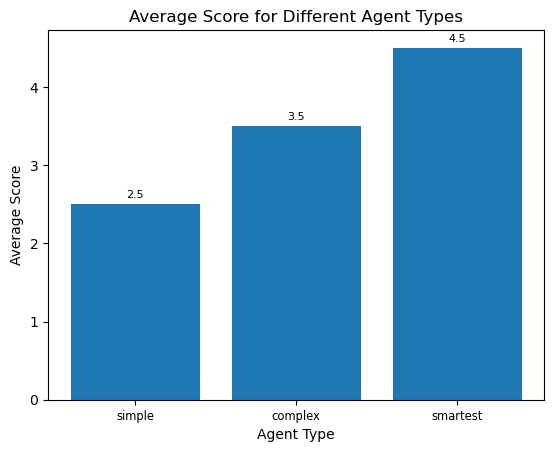

In [8]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["savefig.directory"] = "~/Desktop" # default for plots saved from GUI

# dummy values for illustration
agent_types = np.array(['simple','complex','smartest'])
average_scores = np.array([2.5,3.5,4.5])

plt.xlabel('Agent Type')
plt.ylabel('Average Score')
plt.title('Average Score for Different Agent Types')
plt.bar(agent_types, average_scores)
plt.xticks(agent_types, size='small')
for a, b in zip(agent_types, average_scores):
    plt.text(a, b+0.05, '%.1f' % b, ha='center', va='bottom', fontsize=8)
# plt.savefig('plot.png') # saves to home directory by default
plt.show(block=True) # if you run separately, block Python until figure is closed